In [ ]:
# Necessary Imports

# Install's latest version of tensorflow if not up-to-date or not installed on machine
!pip install tensorflow
import cv2
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import os
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image

# Displays current tensorflow version
tf.__version__

: 

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Path to Kaggle Input
path = "D:/monument-prediction/Indian-monuments/images"
# Walk through the directory and list number of files
for dirpath, dirnames, filenames in os.walk(path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'D:/monument-prediction/Indian-monuments/images'.
There are 23 directories and 0 images in 'D:/monument-prediction/Indian-monuments/images\test'.
There are 0 directories and 31 images in 'D:/monument-prediction/Indian-monuments/images\test\Ajanta Caves'.
There are 0 directories and 36 images in 'D:/monument-prediction/Indian-monuments/images\test\alai_darwaza'.
There are 0 directories and 35 images in 'D:/monument-prediction/Indian-monuments/images\test\alai_minar'.
There are 0 directories and 30 images in 'D:/monument-prediction/Indian-monuments/images\test\basilica_of_bom_jesus'.
There are 0 directories and 34 images in 'D:/monument-prediction/Indian-monuments/images\test\Charar-E- Sharif'.
There are 0 directories and 40 images in 'D:/monument-prediction/Indian-monuments/images\test\charminar'.
There are 0 directories and 30 images in 'D:/monument-prediction/Indian-monuments/images\test\Chhota_Imambara'.
There are 0 directories and 34 images in

In [8]:
# append the training and the testing paths to the original path
train_dir =  path + "/train/"
test_dir = path + "/test/"
train_dir, test_dir

('D:/monument-prediction/Indian-monuments/images/train/',
 'D:/monument-prediction/Indian-monuments/images/test/')

In [9]:
# get all the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['Ajanta Caves', 'Charar-E- Sharif', 'Chhota_Imambara',
       'Ellora Caves', 'Fatehpur Sikri', 'Gateway of India',
       'Humayun_s Tomb', 'India gate pics', 'Khajuraho',
       'Sun Temple Konark', 'alai_darwaza', 'alai_minar',
       'basilica_of_bom_jesus', 'charminar', 'golden temple',
       'hawa mahal pics', 'iron_pillar', 'jamali_kamali_tomb',
       'mysore_palace', 'qutub_minar', 'tajmahal', 'tanjavur temple',
       'victoria memorial'], dtype='<U21')

In [10]:
# function used to view an random image
def view_random_image(target_dir, target_class):
    target_folder = target_dir  + target_class
    
  # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib

    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    imggs=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #converting the image to grayscale 
    (thresh, imgbw)=cv2.threshold(imggs, 127, 255, cv2.THRESH_BINARY) #applying threshold operation to convert to balck and white
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img


# def to_grayscale_from_rgb(img):
#     img = tf.image.rgb_to_grayscale(img)
#     return img


def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

Image shape: (396, 612, 3)


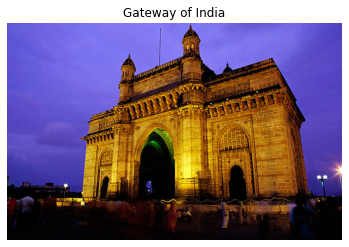

In [11]:
 #View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir, target_class=random.choice(class_names)) # get a random class name

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255,)
test_datagen = ImageDataGenerator(rescale=1/255,)
                                  



# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(300, 300),
                                               batch_size=16,
                                               class_mode='categorical') 

test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=(300, 300),
                                              batch_size=16,
                                              class_mode='categorical')

Found 3643 images belonging to 23 classes.
Found 1049 images belonging to 23 classes.


In [15]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model 
model_1 = Sequential([
  Conv2D(10, 5, activation='relu', input_shape=(300, 300, 3)),
  Conv2D(10, 5, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 5, activation='relu'),
  Conv2D(10, 5, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 5, activation='relu'),
  Conv2D(10, 5, activation='relu'),
#   MaxPool2D(),
#   Conv2D(10, 5, activation='relu'),
#   Conv2D(10, 5, activation='relu'),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(23, activation='softmax') 
])

# Compile the model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [16]:
# Fit the model
history_1 = model_1.fit(train_data, 
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/25
228/228 [==============================] - 25s 102ms/step - loss: 2.8274 - accuracy: 0.1771 - val_loss: 2.8776 - val_accuracy: 0.1897
Epoch 2/25
228/228 [==============================] - 22s 97ms/step - loss: 2.1870 - accuracy: 0.3766 - val_loss: 2.9061 - val_accuracy: 0.2221
Epoch 3/25
228/228 [==============================] - 22s 97ms/step - loss: 1.4243 - accuracy: 0.5762 - val_loss: 3.2095 - val_accuracy: 0.3222
Epoch 4/25
228/228 [==============================] - 22s 96ms/step - loss: 0.6850 - accuracy: 0.7947 - val_loss: 4.3135 - val_accuracy: 0.3870
Epoch 5/25
228/228 [==============================] - 22s 98ms/step - loss: 0.2763 - accuracy: 0.9185 - val_loss: 5.8198 - val_accuracy: 0.3956
Epoch 6/25
228/228 [==============================] - 22s 97ms/step - loss: 0.1278 - accuracy: 0.9646 - val_loss: 8.5719 - val_accuracy: 0.4137
Epoch 7/25
228/228 [==============================] - 22s 97ms/step - loss: 0.0694 - accuracy: 0.9802 - val_loss: 9.5764 - val_accuracy

In [17]:
model_1.evaluate(test_data)

66/66 [==============================] - 5s 75ms/step - loss: 11.1991 - accuracy: 0.4013


[11.199055671691895, 0.40133461356163025]

In [18]:
model_1.save_weights("save_trained_weights.h5")

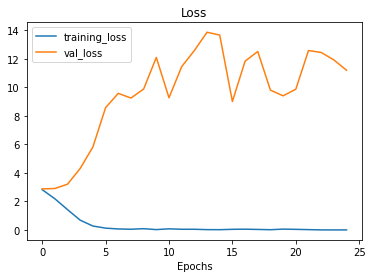

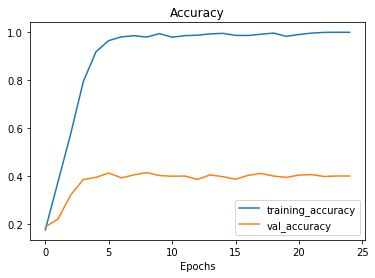

In [20]:
plot_loss_curves(history_1)

In [21]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=300):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
    
  return img

# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

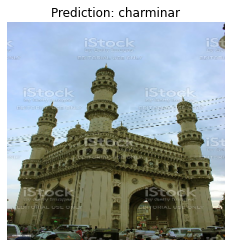

In [23]:
# make a new prediction
pred_and_plot(model_1, "D:/monument-prediction/Indian-monuments/images/test/charminar/35.jpg", class_names)

In [24]:
# save the model
model_1.save("monument-model")